In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import mytrain_lib as ml
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confmat
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV,KFold
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, randint
%matplotlib inline
import importlib

import random
random.seed(0)

In [2]:
path_rawdata    = 'F://TFG//datasets/raw_datasets//'
path_train      = 'F://TFG//datasets//data_train//'
path_graphs     = 'F://TFG//graphs//'
path            = 'F:/TFG/datasets/nature-dataset/'

In [3]:
data             = pd.read_csv(path_rawdata+'matches_wUltPartidos.csv',sep=';',index_col='wyId')

target = []

for match in data.itertuples():
    if match.winner == 0: target.append(0)
    elif match.winner == match.teamId_home: target.append(1)
    else: target.append(2)

data['res'] = target
data['matchId'] = data.index
data.head(3)

,dateutc,competitionId,seasonId,roundId,winner,teamId_home,score_home,scoreHT_home,teamId_away,score_away,...,keyPasses_H,keyPasses_A,ataque_h,defensa_h,ataque_a,defensa_a,ataquedefensa_H,ataquedefensa_A,res,matchId
wyId,,,,,,,,,,,,,,,,,,,,,
2499738,2018-03-31 14:00:00,364,181150,4405654,1633,1633,3,3,1619,0,...,5,6,0.76,1.72,0.96,2.24,0.973546,0.817933,1,2499738
2499799,2017-10-21 11:30:00,364,181150,4405654,1610,1610,4,1,1644,2,...,4,8,0.56,0.84,2.00,1.20,1.316667,0.810784,1,2499799
2499800,2017-10-22 12:30:00,364,181150,4405654,1609,1623,2,1,1609,5,...,16,7,0.60,1.20,0.48,1.72,0.983333,1.399187,2,2499800


In [7]:
# train_data  = ml.FootballMatchesDataset(file = 'train')
# test_data   = ml.FootballMatchesDataset(file = 'test')
train_data  = ml.WyscoutDataset(file = 'train')
test_data   = ml.WyscoutDataset(file = 'test')

In [12]:
trainmatches = train_data.matches
testmatches  = test_data.matches
trainmatches.shape

torch.Size([1100])

In [9]:
def get_odds_res(X):
    odds = [1/X.B365D.to_numpy(),1/(X.B365H.to_numpy()),1/(X.B365A.to_numpy())]
    odds = np.array(odds).T
    res = np.array(X.res)
    return odds,res

## Baseline I: max odds

In [10]:
odds,res = get_odds_res(data.loc[trainmatches])
pred = np.argmax(odds,axis=1)
assert len(pred) == len(res)
np.mean(pred==res)

0.55

In [14]:
importlib.reload(ml)

<module 'mytrain_lib' from 'f:\\TFG\\code\\mytrain_lib.py'>

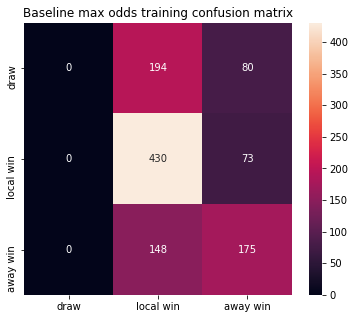

In [15]:
ml.dispConfusionMatrix(confmat(res,pred,labels=[0,1,2]),'Baseline max odds training confusion matrix',filename='confmat_base_maxodds_train',save=True,size=(6,5))

#### Baseline test

In [16]:
odds,res = get_odds_res(data.loc[testmatches])
pred = np.argmax(odds,axis=1)
assert len(pred) == len(res)
np.mean(pred==res)

0.5445859872611465

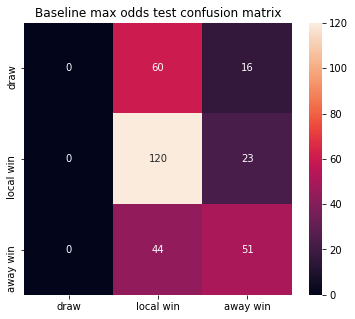

In [17]:
ml.dispConfusionMatrix(confmat(res,pred,labels=[0,1,2]),'Baseline max odds test confusion matrix',filename='confmat_base_maxodds_test',save=True,size=(6,5))

## Baseline II: SVM Baseline model

In [18]:
odds,res = get_odds_res(data.loc[trainmatches])
rand_list = {"C": uniform(2, 10),
             "gamma": uniform(0.1, 1),
             "degree": uniform(2,10),
             "kernel":['linear','poly','rbf']}

svm = SVC(random_state=1)

In [19]:
rand_search = RandomizedSearchCV(svm, param_distributions=rand_list, n_iter=50, n_jobs=4, cv=3, random_state=0) 
rand_search.fit(odds,res)
cv_results = pd.DataFrame(rand_search.cv_results_)

In [20]:
cv_results.sort_values('rank_test_score')[:3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,0.025666,0.000471,0.019335,0.000472,2.992804,11.698091,0.75314,rbf,"{'C': 2.9928035035897387, 'degree': 11.6980906...",0.553134,0.53951,0.546448,0.546364,0.005562,1
49,0.028697,0.002053,0.020000,0.002831,4.378928,11.34214,0.713966,rbf,"{'C': 4.378928213745086, 'degree': 11.34213997...",0.550409,0.53951,0.546448,0.545455,0.004505,2
43,0.028994,0.002464,0.020337,0.003696,9.220556,10.663823,1.075522,rbf,"{'C': 9.22055599470348, 'degree': 10.663823259...",0.550409,0.53951,0.546448,0.545455,0.004505,2


In [21]:
np.max(cv_results.mean_test_score)

0.5463637130676037

#### Baseline test

In [22]:
odds,res = get_odds_res(data.loc[testmatches])
pred = rand_search.best_estimator_.predict(odds)
assert len(pred) == len(res)
np.mean(pred==res)

0.5477707006369427

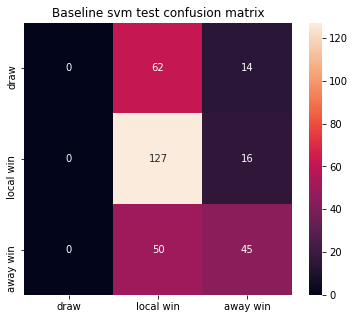

In [23]:
ml.dispConfusionMatrix(confmat(res,pred,labels=[0,1,2]),'Baseline svm test confusion matrix',filename='confmat_base_svm_test',save=True,size=(6,5))

## Baseline III: Random Forest

In [24]:
odds,res = get_odds_res(data.loc[trainmatches])
rand_list = {"n_estimators": randint(5, 200),
             "max_depth": randint(2, 10),
             "min_samples_split": randint(2,100),
             "min_samples_leaf": randint(1,100),
             "max_leaf_nodes": randint(3,20)}

randforest = RandomForestClassifier(random_state=0)

In [25]:
rand_search = RandomizedSearchCV(randforest, param_distributions=rand_list, n_iter=50, n_jobs=4, cv=3, random_state=0) 
rand_search.fit(odds,res)
cv_results = pd.DataFrame(rand_search.cv_results_)

In [26]:
cv_results.sort_values('rank_test_score')[:3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
30,0.121668,0.013673,0.010017,0.000026,7,5,4,96,112,"{'max_depth': 7, 'max_leaf_nodes': 5, 'min_sam...",0.531335,0.558583,0.551913,0.547277,0.011597,1
21,0.126710,0.004192,0.012311,0.002615,5,5,43,79,117,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",0.531335,0.558583,0.551913,0.547277,0.011597,1
19,0.102668,0.005802,0.010001,0.001438,5,3,96,71,99,"{'max_depth': 5, 'max_leaf_nodes': 3, 'min_sam...",0.534060,0.542234,0.562842,0.546379,0.012110,3


In [27]:
np.max(cv_results.mean_test_score)

0.5472769414789337

#### Baseline test

In [28]:
odds,res = get_odds_res(data.loc[testmatches])
pred = rand_search.best_estimator_.predict(odds)
assert len(pred) == len(res)
np.mean(pred==res)

0.5414012738853503

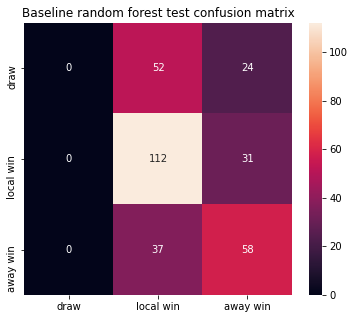

In [29]:
ml.dispConfusionMatrix(confmat(res,pred,labels=[0,1,2]),'Baseline random forest test confusion matrix',filename='confmat_base_randforest_test',save=True,size=(6,5))

## Baseline IV: Multi-layer Perceptron

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [31]:
class BettingDataset(Dataset):
    def __init__(self,odds,res):
        self.data       = torch.tensor(odds).float()
        self.labels     = F.one_hot(torch.tensor(res),num_classes=3).float()
        
    def __len__(self):
        return len(self.data)

    def shape(self):
        return self.data.shape

    def __getitem__(self,idx):
        sample  = self.data[idx]
        label   = self.labels[idx]
        return sample, label, -1


class NeuralNetwork(nn.Module):
    def __init__(self, input_feature, ouput_classes, hidden_neurons=5):
        super().__init__()
        
        self.h1 = nn.Linear(in_features=input_feature,out_features=hidden_neurons)
        self.bn = nn.BatchNorm1d(hidden_neurons)
        self.out = nn.Linear(hidden_neurons,ouput_classes)

    def forward(self,x):
        x = self.h1(x)
        x = F.relu(self.bn(x))
        return F.softmax(self.out(x),1)    

    def reset_weights(self):
        self.h1.reset_parameters()
        self.bn.reset_parameters()
        self.out.reset_parameters()    

In [32]:
model = NeuralNetwork(3,3,3)
train_data = BettingDataset(odds,res)
train_data[0]

(tensor([0.2639, 0.6024, 0.1905]), tensor([0., 1., 0.]), -1)

In [33]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
kfold = KFold(n_splits=3,shuffle=True,random_state=0)
ml.log = {}
error, accuracy_train, accuracy_test,_ = ml.train_wCrossValidation(model,nn.BCELoss(),
                                            optimizer,train_data,kfold,epochs=100,bat_size=32)
ml.save_logging(datetime.now().strftime("_%m%d_%H%M%S"), title='baseline_cv')

TypeError: train_wCrossValidation() got multiple values for argument 'epochs'

In [34]:
np.mean(np.array(accuracy_test)[:,-1])

NameError: name 'accuracy_test' is not defined

#### Baseline Test

In [ ]:
odds,res   = get_odds_res(data.loc[testmatches])
test_data  = BettingDataset(odds,res)
testloader = DataLoader(test_data,32,shuffle=True)

In [ ]:
importlib.reload(ml)
acc_test, cm = ml.test_model(model,testloader)
acc_test

In [ ]:
ml.dispConfusionMatrix(cm,'Baseline MLP 1x3 test confusion matrix',
                        filename='confmat_base_mlp1x3_test',save=True,size=(6,5))